In [1]:
%matplotlib inline  
from IPython.display import clear_output
from math import isnan
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import FloatSlider, BoundedFloatText, Dropdown, Button, BoundedIntText, IntSlider, Button, jslink
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

TYPE_WALL = 'стена'
TYPE_PIPE = 'труба'
TYPE_WINDOW = 'окно'


surface_type_input = Dropdown(
    options=[TYPE_WALL, TYPE_PIPE, TYPE_WINDOW],
    value=TYPE_WALL,
    description='Тип поверхности'
)

TYPE_SONATA = 'Соната-АВ'
TYPE_VNG = 'VNG-012GL'

defence_type_input = Dropdown(
    options=[TYPE_SONATA, TYPE_VNG],
    value=TYPE_SONATA,
    description='Виброакустич. защита'
)

LEVEL_MEDIUM = 'средний'
LEVEL_LOUD = 'громкий'
LEVEL_VERY_LOUD = 'очень громкий'

signal_level_input = Dropdown(
    options=[LEVEL_MEDIUM, LEVEL_LOUD, LEVEL_VERY_LOUD],
    value=LEVEL_MEDIUM,
    description='Уровень скрываемого сигнала'
)


PROFILE_MIN = 'минимальный'
PROFILE_MED = 'средний'
PROFILE_MAX = 'максимальный'

profile_input = Dropdown(
    options=[PROFILE_MIN, PROFILE_MED, PROFILE_MAX],
    value=PROFILE_MED,
    description='Профиль защиты'
)


clarity_input_text = BoundedFloatText(
    description='Слов. разб. речи',
    value=0.38,
    min=0.0,
    max=1.0,
)
clarity_input = FloatSlider(
    min=0.0,
    max=1.0,
    step=0.001,
    value=0.38
)

link = jslink((clarity_input_text, 'value'), (clarity_input, 'value'))


width_input_text = BoundedIntText(
    description='Ширина (в клетках)',
    min=1,
    max=100,
    value=5
)
width_input = IntSlider(
    min=1,
    max=100,
    value=5
)
link = jslink((width_input_text, 'value'), (width_input, 'value'))



height_input_text = BoundedIntText(
    description='Высота (в клетках)',
    min=1,
    max=100,
    value=5
)
height_input = IntSlider(
    min=1,
    max=100,
    value=5
)
link = jslink((height_input_text, 'value'), (height_input, 'value'))


run_btn = Button(description='Запуск')

        

In [2]:
vibes = [
    (2, 3)
]

In [3]:
def color(value, clarity):
    if value <= clarity:
        return 'green'
    elif value + 0.1 <= clarity:
        return 'yellow'
    else:
        return 'red'



def render(width, height, vibes, tiles, tile_size=0.1, clarity=0.4): 
    fig1 = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax1 = fig1.add_subplot(111, aspect='equal')
    for p in [

                
            patches.Rectangle(
                    np.multiply(tiles[i]["position"], tile_size),
                    tile_size,
                    tile_size,
                    facecolor=color(tiles[i]['value'], clarity)
                    ) for i in range(len(tiles))
    ]:
        ax1.add_patch(p)
        for vibe in vibes:
            circle = plt.Circle(
                (vibe[0] * tile_size + tile_size / 2, vibe[1] * tile_size + tile_size / 2), 
                tile_size / 3, 
                color='Blue'
            )
            ax1.add_artist(circle)
    plt.axis([0, np.ceil(tile_size * width), 0, np.ceil(tile_size * height)])
            


In [4]:
# Переводим все значения из таблиц А.1-А.8
# исх. данные
# уровень тест сигнала средний
# уровень излучения виброизлучателя максимальный
#датчик-соната АВ тяжелый
# ограждающая конструкция стена


#Уровень виброускорения от тестового речевого сигнала (Средняя речь) Vсi, дБ
def Vci(i):
    return [37, 42.5, 48.8, 53.1, 47.9, 31.6, 29.3][i - 1]

#Значение  формантного параметра речи в полосе DAi, дБ
def DA(i):
    return [25, 18, 14, 9, 6, 5, 4][i - 1]

def A(i):
    return [25, 18, 14, 9, 6, 5, 4][i - 1]

def k(i):
    return [0.01, 0.03, 0.12, 0.2, 0.3, 0.26, 0.07][i - 1]

def Vc(i):
    return [37, 42.5, 48.8, 53.1, 47.9, 31.6, 29.3][i - 1]

#Уровень шума от системы защиты V*, дБ
#(уровень максимальный)
def Vstar(i):
    return [25.9, 29.3, 43.6, 61.6, 58.9, 54.1, 54.5][i - 1]

def Ln(i):
    return 10 ** (Vstar(i) / 20)


 
def Lsh1(x, i):
    val = (14.72-1.563*np.log(x))
    if val > 0:
        return 0.05248*Ln(i)*val
    else:
        return 0.05248*Ln(i)
def Lsh2(x, i):    
    val = (28.056-9.437*np.log(x))
    if val > 0:
        return 0.01883*Ln(i)
    else:
        return 0.01883*Ln(i)
def Lsh3(x, i):
    val = (27.961-7.038*np.log(x))
    if val > 0:
        return 0.02137*Ln(i)*val
    else:
        return 0.02137*Ln(i)
def Lsh4(x, i):     
    val = (16.154-1.56*np.log(x))
    if val > 0:
        return 0.04954*Ln(i)*val
    else:
        return 0.04954*Ln(i)
def Lsh5(x, i):    
    val = (17.183-3.705*np.log(x))
    if val > 0:
        return 0.03672*Ln(i)*val
    else:
        0.03672*Ln(i)
def Lsh6(x, i):    
    val = (89.649-41.86*np.log(x))
    if val > 0:
        return 0.00467*Ln(i)*val
    else:
        return 0.00467*Ln(i)
def Lsh7(x, i):    
    val = (45.846-18.85*np.log(x))
    if val > 0:
        return 0.01011*Ln(i)*val
    else:
        return 0.01011*Ln(i)
    
def Lsh(i, x):
    return [Lsh1, Lsh2, Lsh3, Lsh4, Lsh5, Lsh6, Lsh7][i - 1](x, i)

def Vsh(i, x):
    return 20 * np.log10(Lsh(i, x) * (10 ** (-6))) + 120

def q(i, x):
    return Vc(i) - Vsh(i, x)

def Qi(i, x):
    return q(i, x) - DA(i)

def p(i, x):
    Q = Qi(i, x)
    
    val = (0.78 + 5.46 * np.exp(-4.3 * (10 ** -3) * (27.3 - (np.abs(Q)) ** 2))) / (1 + (10 ** (0.1 * np.abs(Q))))
    
    if Q <= 0:
        return val
    else:
        return 1 - val
    
def Ri(i, x):
    return p(i, x) - k(i)

def W(x):
    R = np.sum(Ri(i + 1, x) for i in range(7))
    if isnan(R):
        print('NAN: {}'.format(x))
    if R < 0.15: 
        return 1.54 * (R ** (0.25)) * (1 - np.exp(-11 * R))
    else: 
        return 1 - np.exp(-(11 * R) / (1 + 0.7 * R))


In [5]:
def f(x, y, vibe, tile_size):
    vx, vy = vibe
    distance = np.sqrt(np.sum(np.square([(x - vx) * tile_size, (y - vy) * tile_size])))
    if distance > 0:
        return W(distance)
    else:
        return 0.0

def generate_tile(x, y, vibes, surface_type, defence_type, signal_level, profile, clarity, tile_size):
    values = np.array([f(x, y, v, tile_size) for v in vibes])
    real_value = np.sqrt(np.sum(np.power(values, 2.0)))

    
    return { "position": (x, y), "value": real_value }

In [6]:
def calculate_everything(b):
    clear_output()
    surface_type = surface_type_input.value
    defence_type = defence_type_input.value
    signal_level = signal_level_input.value
    profile = profile_input.value
    clarity = clarity_input.value
    width = width_input.value
    height = height_input.value
    
    if surface_type == TYPE_WALL:
        tile_size = 1.0
    else:
        tile_size = 0.1
    
    tiles = [
        generate_tile(
            x + 1, 
            y + 1, 
            vibes=vibes,
            surface_type=surface_type,
            defence_type=defence_type,
            signal_level=signal_level,
            profile=profile,
            clarity=clarity,
            tile_size=tile_size
        ) 
        for x in range(width) for y in range(height)
    ]
    
    render(width, height, vibes, tiles, tile_size=tile_size, clarity=clarity)


run_btn.on_click(calculate_everything)

/home/moroz/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars


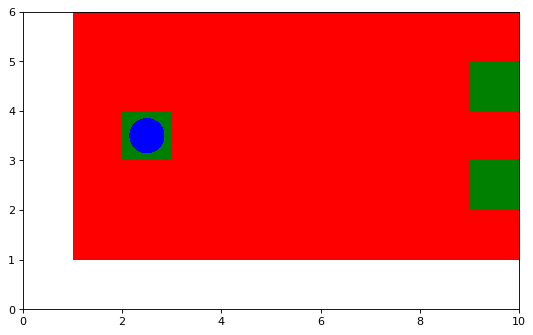

In [7]:


                                    
                                              
display(
    surface_type_input, 
    defence_type_input, 
    signal_level_input,
    profile_input,
    clarity_input_text,
    clarity_input,
    width_input_text, 
    width_input, 
    height_input_text, 
    height_input, 
    run_btn
)
